In [ ]:
#catboost 설치가 되어있지 않은 경우 실행
!pip install catboost

In [ ]:
#shap 설치가 되어있지 않은 경우 실행
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from catboost import CatBoostClassifier

이 대회에서 여러분의 임무는 타이타닉호가 시공간 이상과 충돌하는 동안 승객이 다른 차원으로 이동했는지 여부를 예측하는 것입니다. 이러한 예측을 돕기 위해 함선의 손상된 컴퓨터 시스템에서 복구된 개인 기록 세트가 제공됩니다.

## **0. csv 입력 및 데이터 컬럼 확인**

In [ ]:
df = pd.read_csv('train.csv', delimiter=',')
df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


**train.csv**- 약 2/3 (~8700명)의 승객에 대한 개인 기록으로, 훈련 데이터로 사용

1. **PassengerId** - 각 승객에 대한 고유 ID. 각 ID는 gggg_pp 형태를 가지며, 여기서 gggg는 승객이 함께 여행하는 그룹을 나타냄. pp는 그룹 내에서의 번호이며, 그룹에 있는 사람들은 대부분 가족으로 구성

2. **HomePlanet** - 승객이 출발한 행성으로, 일반적으로 그들의 영구 거주 행성

3. **CryoSleep** - 승객이 여행 기간 동안 중단된 애니메이션 상태에 놓이기로 선택했는지 여부를 나타냄.  CryoSleep 상태의 승객들은 객실에 제한

4. **Cabin** - 승객이 머무르는 객실 번호. deck/num/side 형태를 가지며, 여기서 side는 Port를 나타내는 P 또는 Starboard를 나타내는 S가 됨

5. **Destination** - 승객이 하차할 행성

6. **Age** - 승객의 나이

7. **VIP** - 승객이 여행 동안 특별한 VIP 서비스를 이용했는지 여부

8. **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - 승객이 타이타닉 우주선의 다양한 고급 편의 시설에서 청구한 금액

13. **Name**- 승객의 이름

14. **Transported** - 승객이 다른 차원으로 이동했는지 여부. 이것이 목표로, 예측하려는 열

**test.csv** - 나머지 1/3 (~4300명)의 승객에 대한 개인 기록으로, 테스트 데이터로 사용되며 이 세트의 승객에 대해 Transported 값을 예측하는 것이 작업

**sample_submission.csv** - 올바른 형식의 제출 파일

**PassengerId** - 테스트 세트의 각 승객에 대한 ID

**Transported** - 목표로 각 데이터셋 설명

총 14개의 데이터 걸럼이 존재 마지막 컬럼 1개는 결과값 컬럼

info 결과 데이터셋 열의 수는 8693개

모든 컬럼에서 결측치가 발생하는 것을 확인

In [ ]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [ ]:
df.describe(exclude=['float']).round(1)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
count,8693,8492,8476,8494,8511,8490,8493,8693
unique,8693,3,2,6560,3,2,8473,2
top,9280_02,Earth,False,G/734/S,TRAPPIST-1e,False,Ankalik Nateansive,True
freq,1,4602,5439,8,5915,8291,2,4378


## **1. 결측치 확인 및 제거**

In [ ]:
missing_values = df.isnull().sum()

missing_values

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
missing_values = df.isnull().sum()

missing_values

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6606 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6606 non-null   object 
 1   HomePlanet    6606 non-null   object 
 2   CryoSleep     6606 non-null   object 
 3   Cabin         6606 non-null   object 
 4   Destination   6606 non-null   object 
 5   Age           6606 non-null   float64
 6   VIP           6606 non-null   object 
 7   RoomService   6606 non-null   float64
 8   FoodCourt     6606 non-null   float64
 9   ShoppingMall  6606 non-null   float64
 10  Spa           6606 non-null   float64
 11  VRDeck        6606 non-null   float64
 12  Name          6606 non-null   object 
 13  Transported   6606 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 729.0+ KB


## **2. 예측값 분포도**

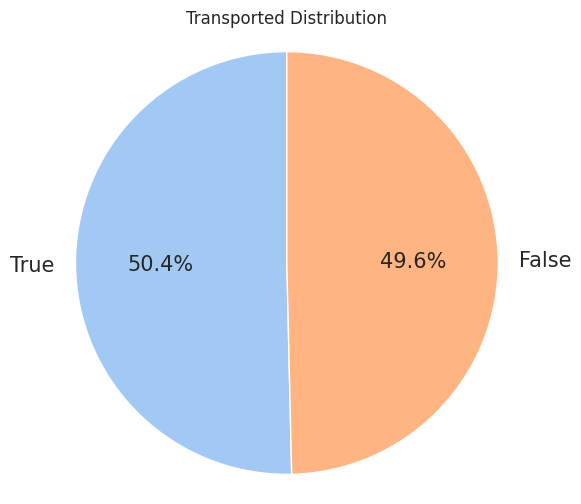

In [ ]:
# 그림 크기 설정
plt.figure(figsize=(6, 6))

# 원형 그래프
sns.set(style="whitegrid")
plt.pie(df['Transported'].value_counts(), labels=df['Transported'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'), textprops={'fontsize': 15})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Transported Distribution")
plt.show()

## **3. 각 컬럼별 이진 값 상관관계 분석**

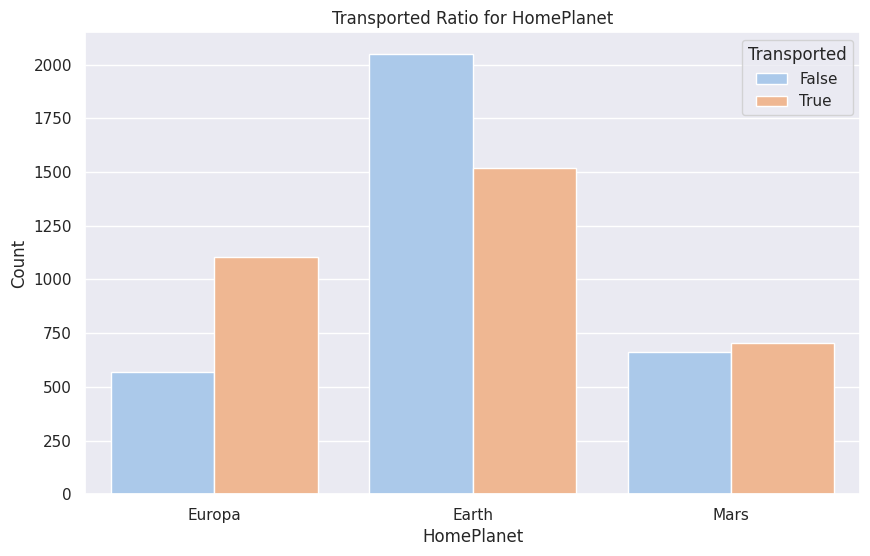

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_theme()

sns.countplot(data=df, x='HomePlanet', hue='Transported', palette='pastel')

plt.title('Transported Ratio for HomePlanet')
plt.xlabel('HomePlanet')
plt.ylabel('Count')
plt.show()

False와 True의 비율을 비교했을 때, 가장 True가 많은 행성은 Europa이며, 가장 False가 많은 행성은 Earth입니다.

Mars는 True와 False의 비율이 크게 차이나지 않았습니다.

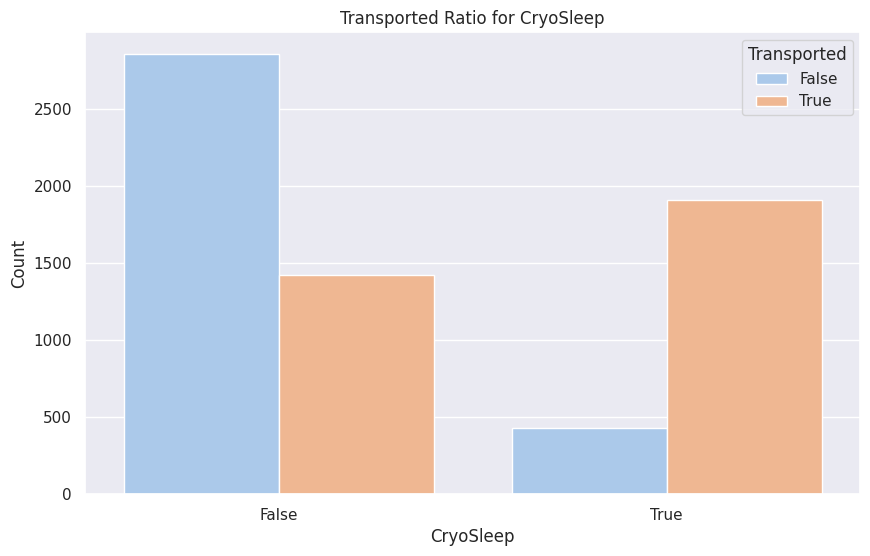

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_theme()

sns.countplot(data=df, x='CryoSleep', hue='Transported', palette='pastel')

plt.title('Transported Ratio for CryoSleep')
plt.xlabel('CryoSleep')
plt.ylabel('Count')
plt.show()

**인사이트:**

승객이 CryoSleep, 즉 냉동수면 여부에 따른 결과가 매우 유의미했습니다.

냉동수면인 경우 True의 비율이 월등히 높았으며, 반면 냉동수면이 아닌 경우 False의 비율이 월등히 높았습니다.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same e

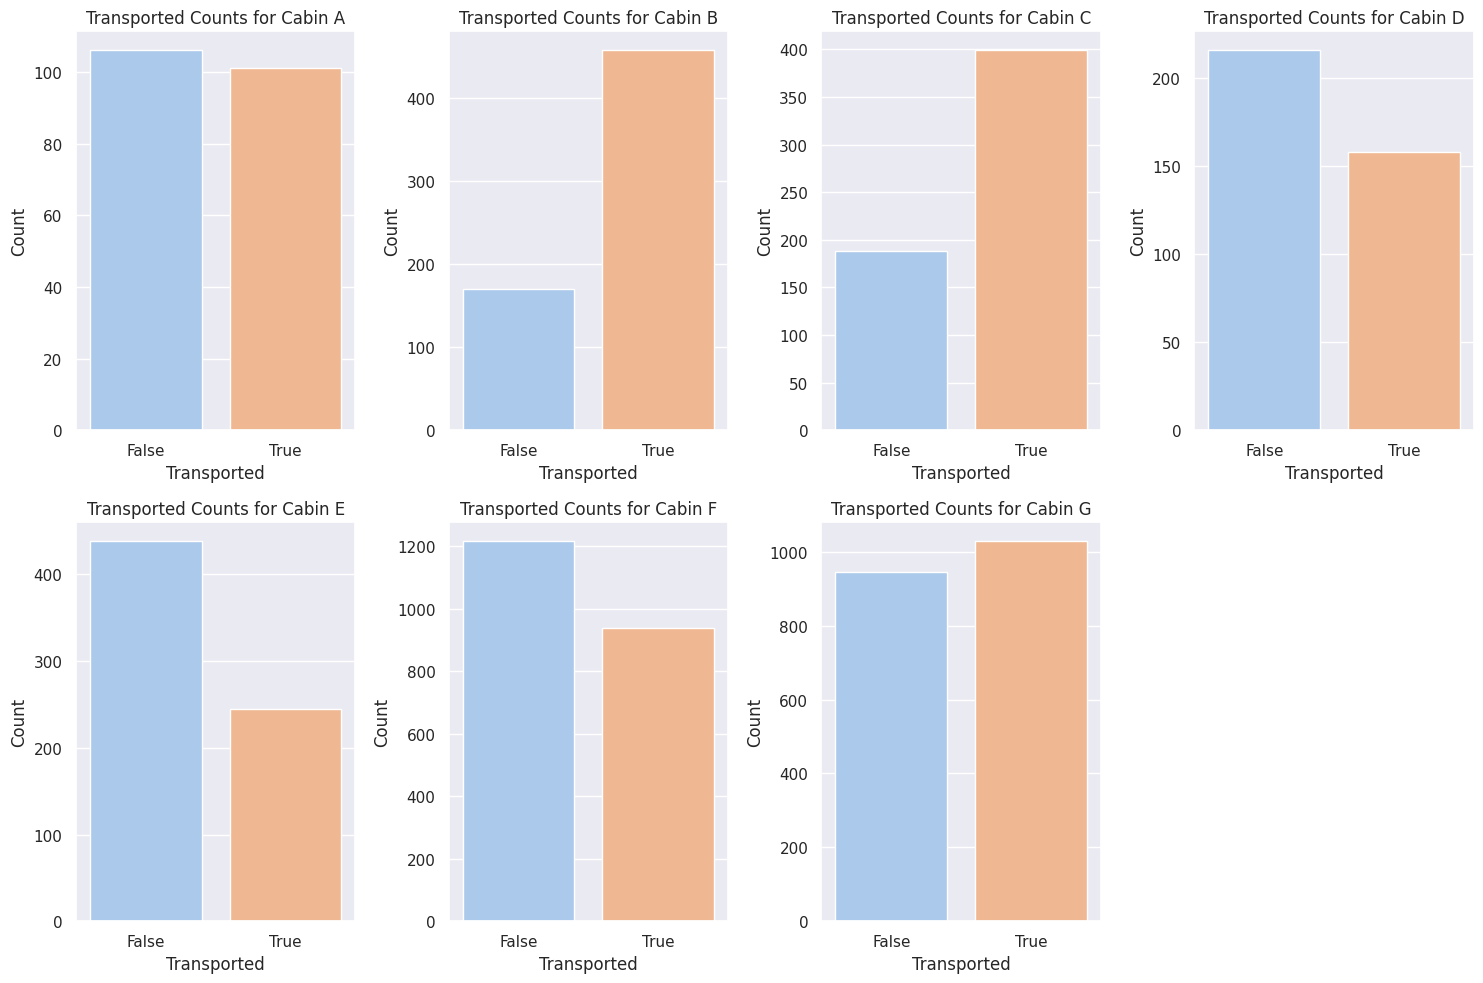

In [ ]:
# A부터 G까지의 Cabin에 대한 따로운 그래프 그리기
cabin_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

plt.figure(figsize=(15, 10))
sns.set_theme()

for idx, cabin_category in enumerate(cabin_categories, 1):
    # 'Cabin'이 앞자리가 현재 cabin_category인 경우에 대한 데이터프레임 생성
    cabin_category_df = df[df['Cabin'].str[0] == cabin_category]

    # subplot 설정
    plt.subplot(2, 4, idx)

    # 'Transported'에 대한 바 그래프 그리기
    sns.countplot(data=cabin_category_df, x='Transported', palette='pastel')

    plt.title(f'Transported Counts for Cabin {cabin_category}')
    plt.xlabel('Transported')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

**인사이트:**

객실 클래스의 앞자리에 따른 그래프를 분석해봤습니다.

True의 비율이 가장 높은 객실 클래스는 B와 C이며, 반면에 False의 비율이 가장 높은 객실 클래스는 D와 E입니다.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



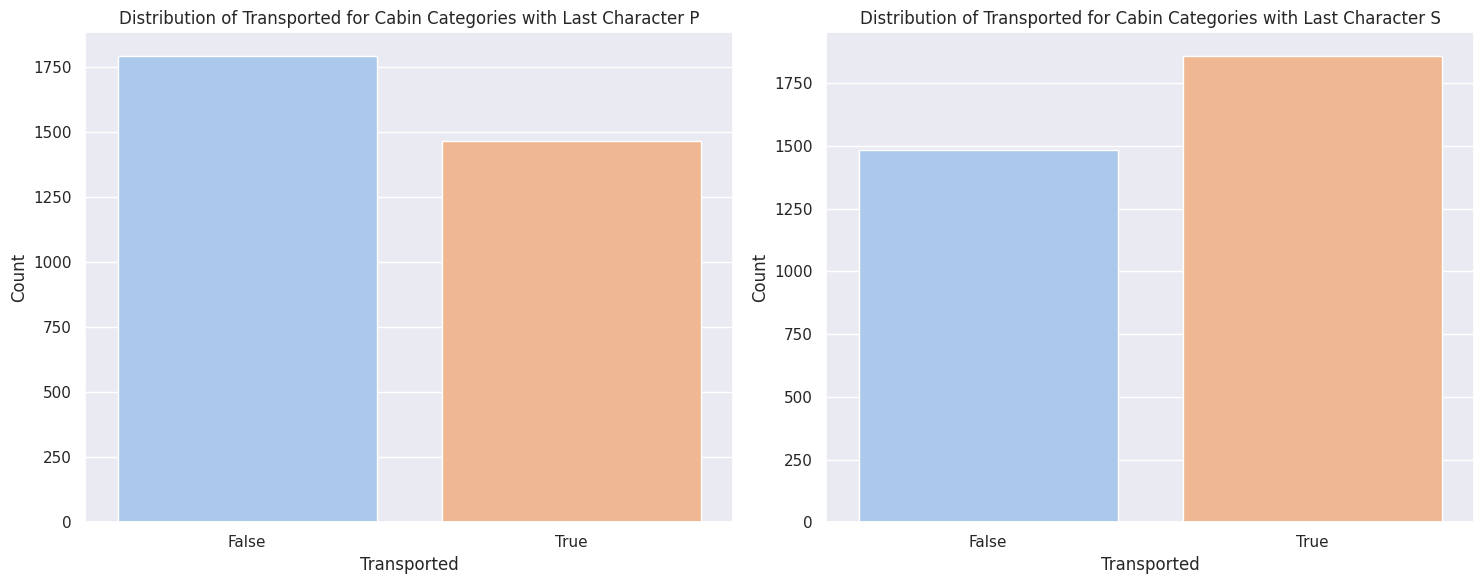

In [ ]:
# 'Cabin'의 맨 뒷자리가 'P' 또는 'S'인 경우에 대한 데이터프레임 생성
cabin_p_df = df[df['Cabin'].str[-1] == 'P']
cabin_s_df = df[df['Cabin'].str[-1] == 'S']

# 그림 크기 설정
plt.figure(figsize=(15, 6))

# 'Cabin'의 맨 뒷자리가 'P'인 경우에 대한 각 Transported의 비율을 나타내는 바 그래프 그리기
plt.subplot(1, 2, 1)
sns.countplot(data=cabin_p_df, x='Transported', palette='pastel')
plt.title('Distribution of Transported for Cabin Categories with Last Character P')
plt.xlabel('Transported')
plt.ylabel('Count')

# 'Cabin'의 맨 뒷자리가 'S'인 경우에 대한 각 Transported의 비율을 나타내는 바 그래프 그리기
plt.subplot(1, 2, 2)
sns.countplot(data=cabin_s_df, x='Transported', palette='pastel')
plt.title('Distribution of Transported for Cabin Categories with Last Character S')
plt.xlabel('Transported')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

**인사이트:**

객실 클래스의 앞뒷자리에 따른 그래프를 분석해봤습니다.

뒷자리가 P인 경우 False의 비율이 높았으며 뒷자리가 S인 경우 True의 비율이 높았습니다.

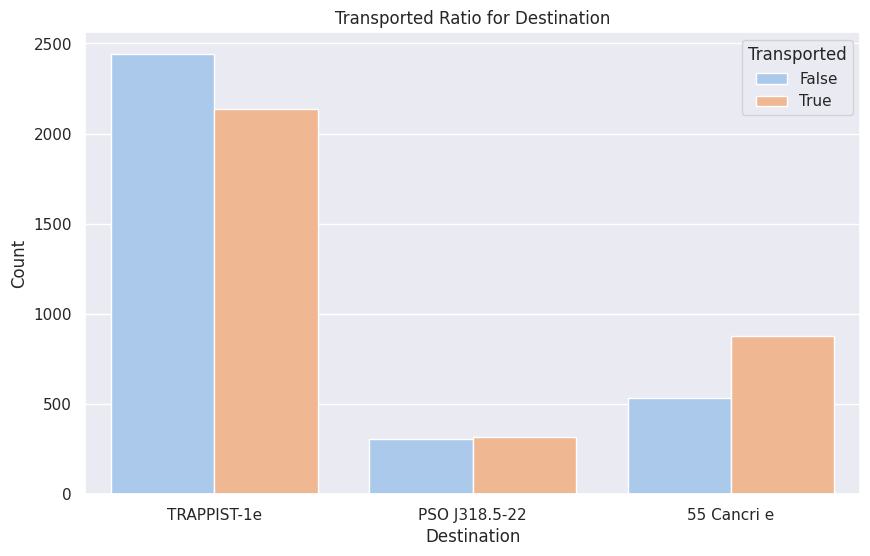

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_theme()

sns.countplot(data=df, x='Destination', hue='Transported', palette='pastel')

plt.title('Transported Ratio for Destination')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.show()

**인사이트:**

도착지에 따른 Transported 결과를 살펴보았습니다.

TRAPPIST-1e로 향하는 경우 False의 비율이 높았으며, 반면 55 Cancri e로 향하는 경우 True의 비율이 가장 높았습니다.

Text(0.5, 0, 'Age (years)')

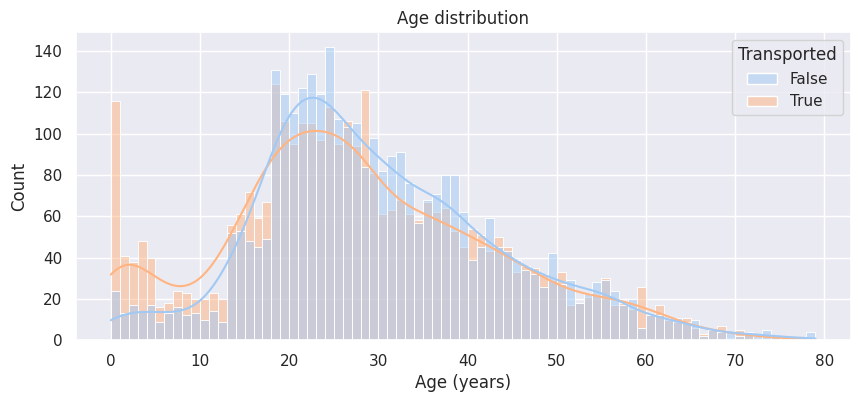

In [ ]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=df, x = 'Age', hue='Transported', binwidth=1, kde=True, palette='pastel')

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

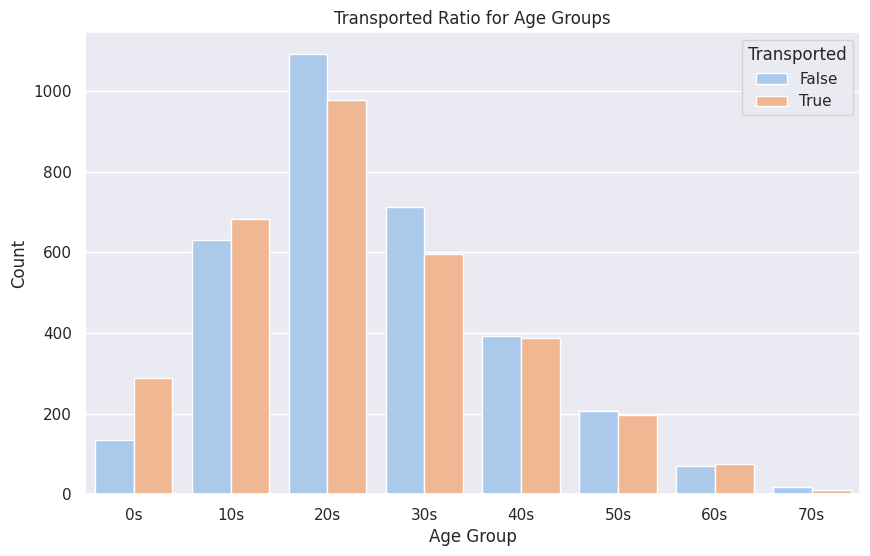

In [ ]:
# 나이를 10단위로 범주화하여 새로운 열 'AgeGroup' 추가
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80], labels=['0s','10s','20s', '30s', '40s', '50s', '60s', '70s'])

plt.figure(figsize=(10, 6))
sns.set_theme()

sns.countplot(data=df, x='AgeGroup', hue='Transported', palette='pastel')

plt.title('Transported Ratio for Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

**인사이트:**

나이가 0-20대인 경우 True의 비율이 더 높았으며, 20-30대인 경우 False의 비율이 더 높았습니다.

40-70대는 True와 False의 비율에 큰 차이가 없었습니다.

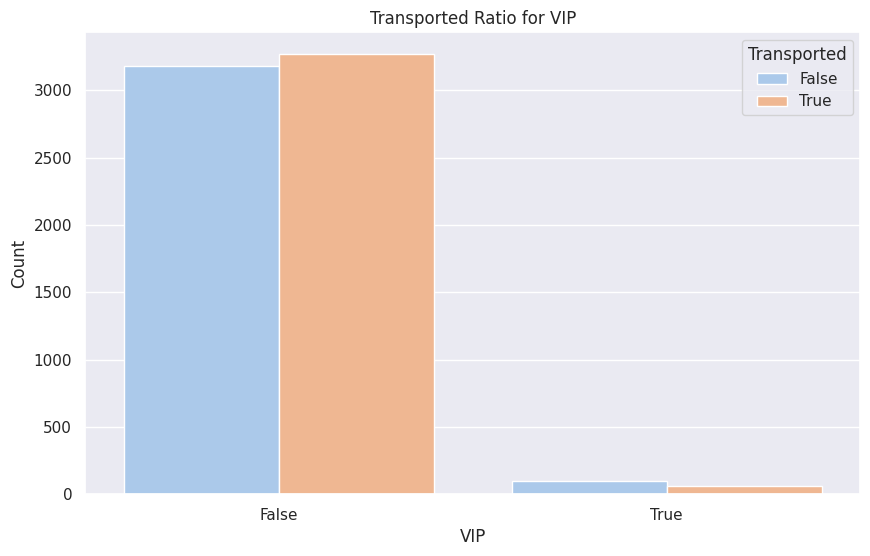

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_theme()

sns.countplot(data=df, x='VIP', hue='Transported', palette='pastel')

plt.title('Transported Ratio for VIP')
plt.xlabel('VIP')
plt.ylabel('Count')
plt.show()

**인사이트:**

VIP인 경우 False의 비율이 더 높았으며, VIP가 아닌 경우 True의 비율이 더 높았습니다.

In [ ]:
average_room_service = df['RoomService'].mean().round(1)

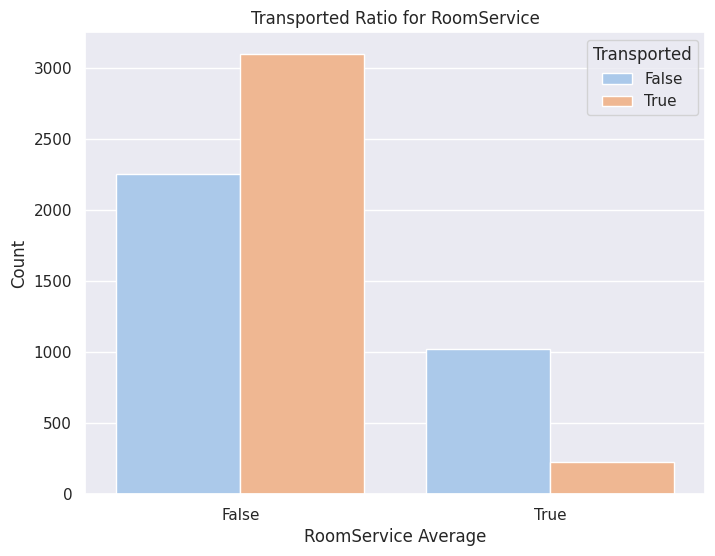

In [ ]:
# 'RoomServiceAboveAverage' 열 생성: RoomService 값이 평균보다 높으면 True, 아니면 False
df['RoomServiceAverage'] = df['RoomService'] > average_room_service

plt.figure(figsize=(8, 6))
sns.set_theme()

sns.countplot(data=df, x='RoomServiceAverage', hue='Transported', palette='pastel')

plt.title('Transported Ratio for RoomService')
plt.xlabel('RoomService Average')
plt.ylabel('Count')
plt.show()

**인사이트:**

room service의 평균을 계산하여 비교를 하였습니다.

평균보다 높은 경우 False의 비율이 더 높았으며, 평균보다 낮은 경우 True의 비율이 더 높은 그래프를 그렸습니다.

In [ ]:
average_food_count = df['FoodCourt'].mean().round(1)

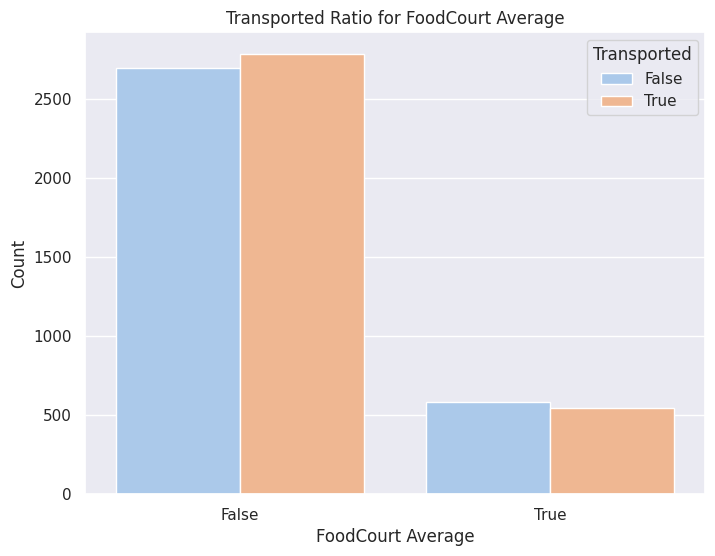

In [ ]:
df['FoodCourtAverage'] = df['FoodCourt'] > average_food_count

plt.figure(figsize=(8, 6))
sns.set_theme()

sns.countplot(data=df, x='FoodCourtAverage', hue='Transported', palette='pastel')

plt.title('Transported Ratio for FoodCourt Average')
plt.xlabel('FoodCourt Average')
plt.ylabel('Count')
plt.show()

**인사이트:**

Food court의 평균보다 높은 경우 Flase의 비율이 근소하게 높았으며 낮은 경우 True의 비율이 근소하게 낮았습니다.

Food court는 크게 관여하지 않는 것으로 판단됩니다.

In [ ]:
average_shoppingmall = df['ShoppingMall'].mean().round(1)

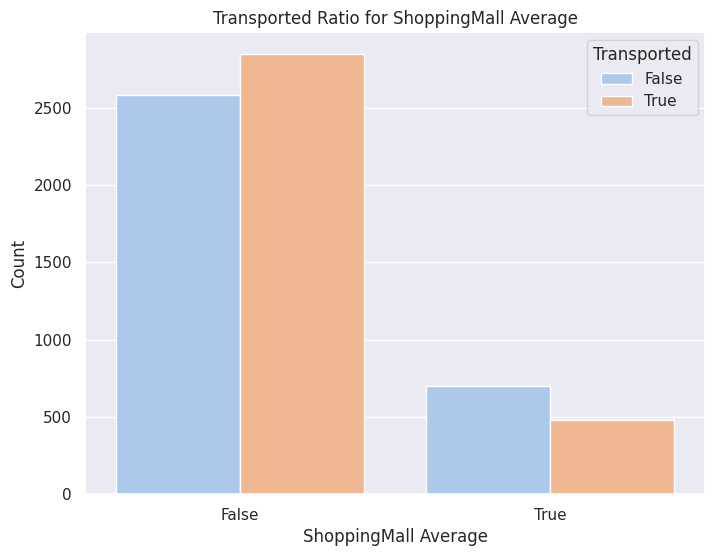

In [ ]:
df['ShoppingMallAverage'] = df['ShoppingMall'] > average_shoppingmall

plt.figure(figsize=(8, 6))
sns.set_theme()

sns.countplot(data=df, x='ShoppingMallAverage', hue='Transported', palette='pastel')

plt.title('Transported Ratio for ShoppingMall Average')
plt.xlabel('ShoppingMall Average')
plt.ylabel('Count')
plt.show()

**인사이트:**
shoppingmall의 평균에서는 평균보다 높은 경우 False의 비율이 높았으며, 평균보다 낮은 경우 True의 비율이 높았습니다.

In [ ]:
average_spa = df['Spa'].mean().round(1)

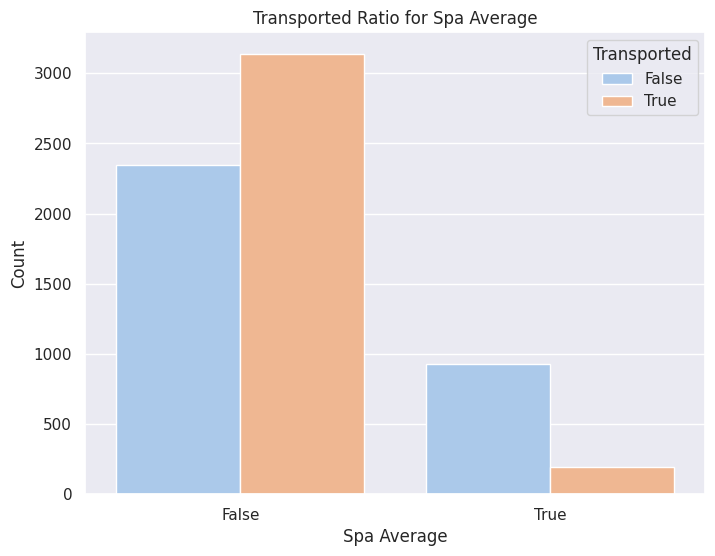

In [ ]:
df['SpaAverage'] = df['Spa'] > average_spa

plt.figure(figsize=(8, 6))
sns.set_theme()

sns.countplot(data=df, x='SpaAverage', hue='Transported', palette='pastel')

plt.title('Transported Ratio for Spa Average')
plt.xlabel('Spa Average')
plt.ylabel('Count')
plt.show()

**인사이트:**
spa의 평균에서는 평균보다 높은 경우 False의 비율이 높았으며, 평균보다 낮은 경우 True의 비율이 높았습니다.

In [ ]:
average_vrdeck = df['VRDeck'].mean().round(1)

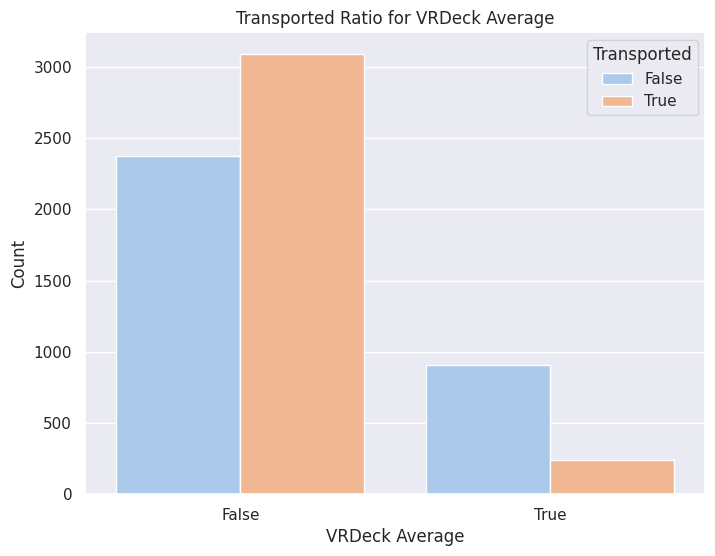

In [ ]:
df['VRDeckAverage'] = df['VRDeck'] > average_vrdeck

plt.figure(figsize=(8, 6))
sns.set_theme()

sns.countplot(data=df, x='VRDeckAverage', hue='Transported', palette='pastel')

plt.title('Transported Ratio for VRDeck Average')
plt.xlabel('VRDeck Average')
plt.ylabel('Count')
plt.show()

**인사이트:**
VRDeck의 평균에서는 평균보다 높은 경우 False의 비율이 높았으며, 평균보다 낮은 경우 True의 비율이 높았습니다.

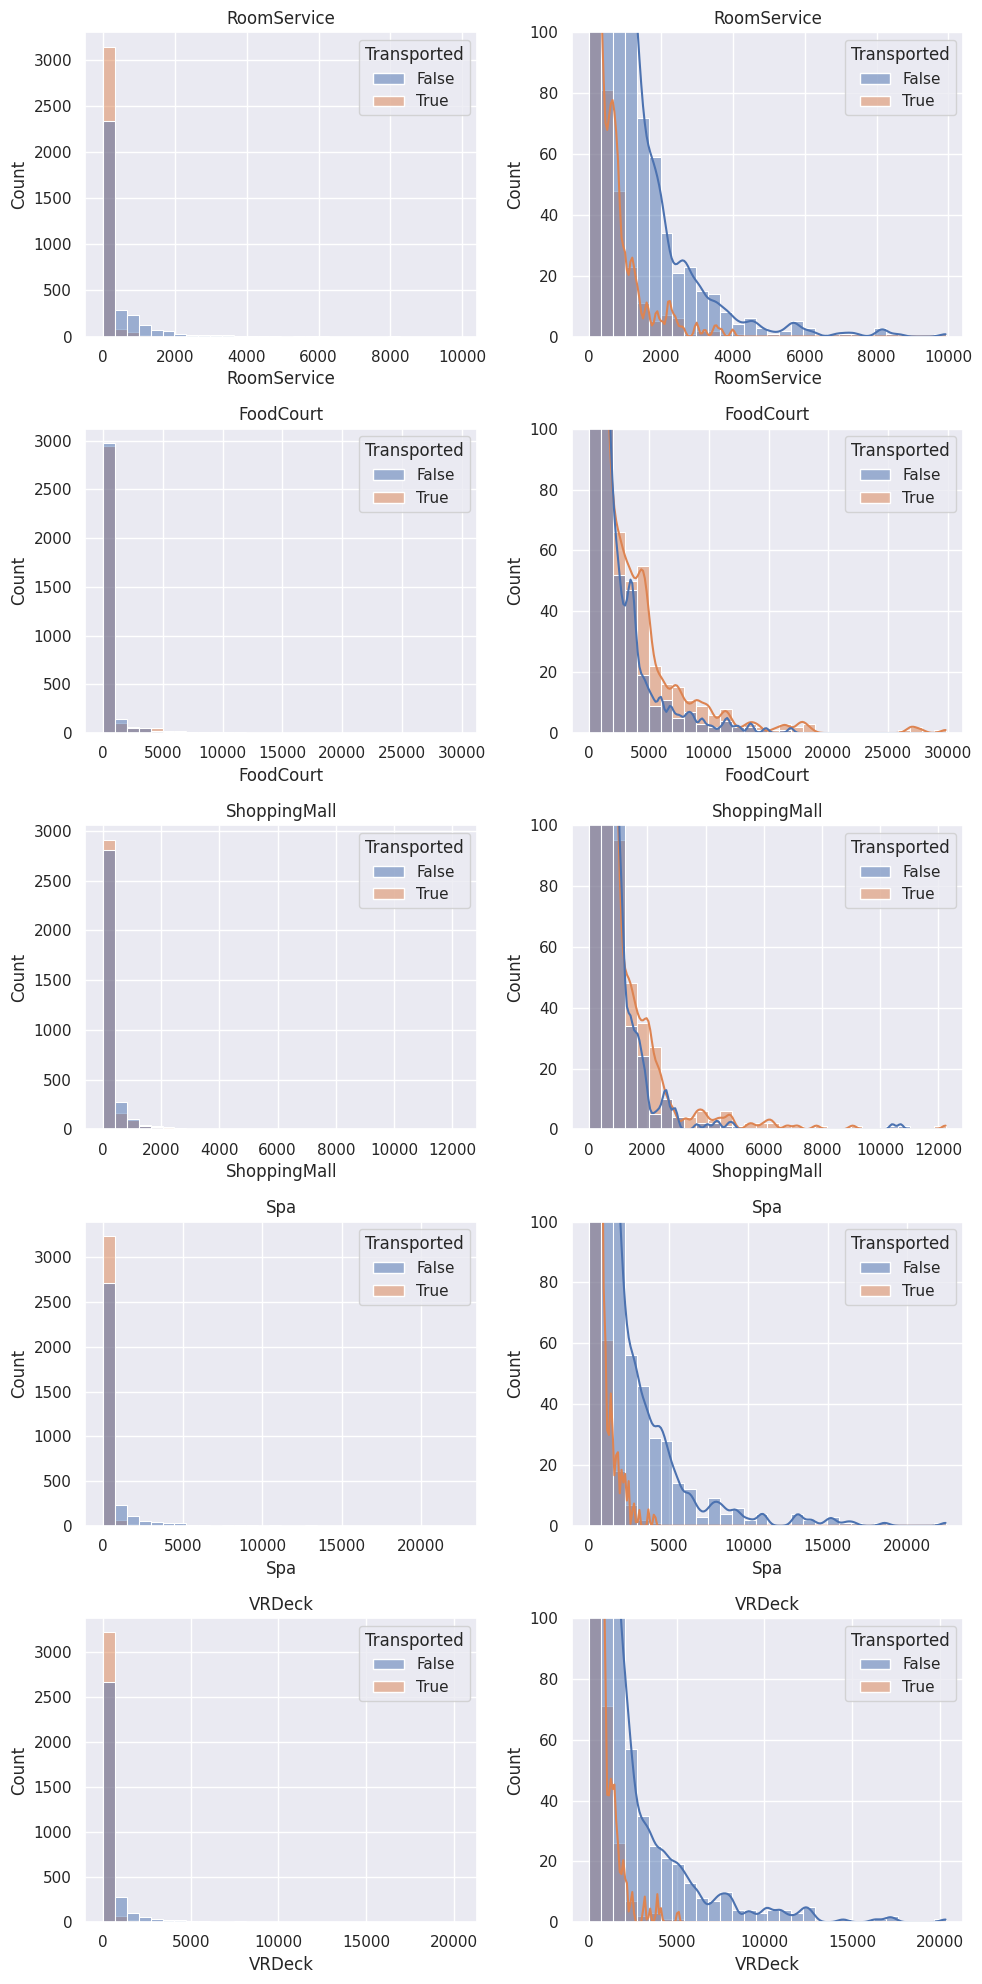

In [ ]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=df, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)

    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=df, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

**주의사항:**

대부분의 사람들은 돈을 아무것도 소비하지 않습니다 (왼쪽에서 확인할 수 있습니다).

소비 분포는 지수적으로 감소합니다 (오른쪽에서 확인할 수 있습니다).

이상치가 몇 개 있습니다.

이상으로 이동한 사람들은 일반적으로 덜 지출하는 경향이 있습니다.

RoomService, Spa 및 VRDeck는 FoodCourt 및 ShoppingMall과는 다른 분포를 가지고 있습니다. 이를 고급 vs 필수 편의시설로 생각할 수 있습니다.

**인사이트:**

5개의 편의시설 전체에서의 총 지출을 추적하는 새로운 기능을 생성합니다.

지출이 없는 경우를 나타내는 이진 특성을 만듭니다 (즉, 총 지출이 0인 경우).

왜곡을 감소시키기 위해 로그 변환을 수행합니다.

# 특성 엔지니어링

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
# New features - training set
train['Age_group']=np.nan
train.loc[train['Age']<=12,'Age_group']='Age_0-12'
train.loc[(train['Age']>12) & (train['Age']<18),'Age_group']='Age_13-17'
train.loc[(train['Age']>=18) & (train['Age']<=25),'Age_group']='Age_18-25'
train.loc[(train['Age']>25) & (train['Age']<=30),'Age_group']='Age_26-30'
train.loc[(train['Age']>30) & (train['Age']<=50),'Age_group']='Age_31-50'
train.loc[train['Age']>50,'Age_group']='Age_51+'

# New features - test set
test['Age_group']=np.nan
test.loc[test['Age']<=12,'Age_group']='Age_0-12'
test.loc[(test['Age']>12) & (test['Age']<18),'Age_group']='Age_13-17'
test.loc[(test['Age']>=18) & (test['Age']<=25),'Age_group']='Age_18-25'
test.loc[(test['Age']>25) & (test['Age']<=30),'Age_group']='Age_26-30'
test.loc[(test['Age']>30) & (test['Age']<=50),'Age_group']='Age_31-50'
test.loc[test['Age']>50,'Age_group']='Age_51+'

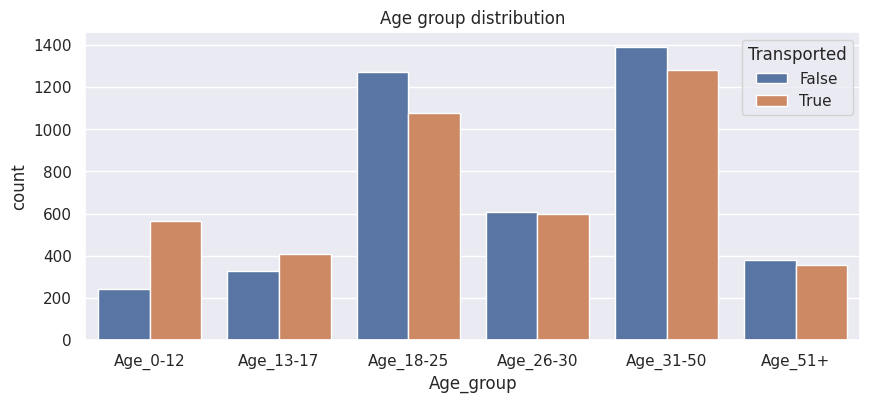

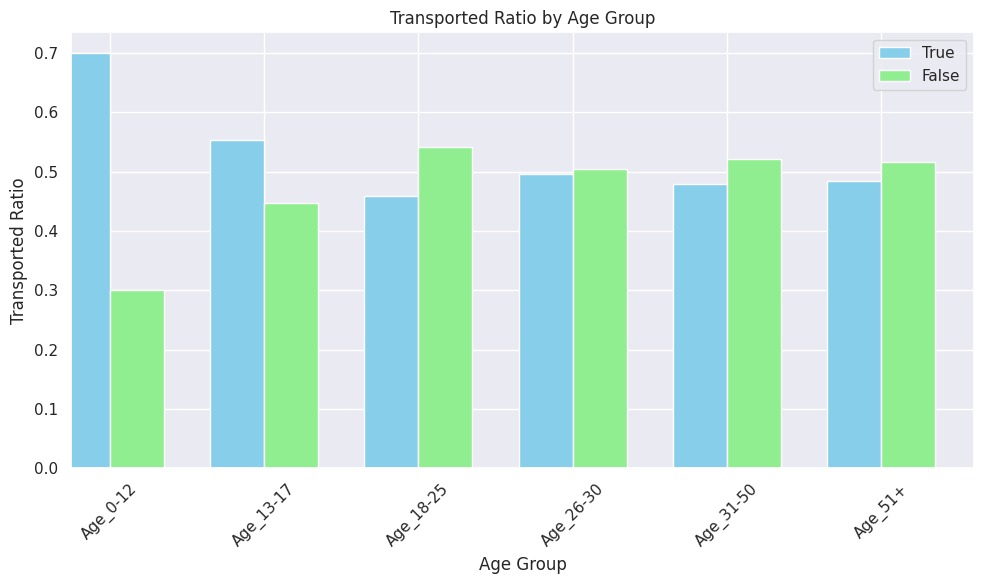

In [ ]:
plt.figure(figsize=(10,4))
g=sns.countplot(data=train, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Age group distribution')

# 각 연령 그룹별 Transported 열의 비율 계산
transported_ratio = train.groupby('Age_group')['Transported'].mean()

# 각 연령 그룹별 Transported 열의 False 비율 계산
transported_false_ratio = 1 - transported_ratio

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
width = 0.35
transported_ratio.plot(kind='bar', color='skyblue', width=width, position=1, label='True')
transported_false_ratio.plot(kind='bar', color='lightgreen', width=width, position=0, label='False')
plt.title('Transported Ratio by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Transported Ratio')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Age Gruop 중 Age_31-50에 인원이 가장 많이 분포하며, Age_13-17 인원이 가장 적다.

그룹별 Transported Ratio 경우, Age_0-12가 True & False가 가장 두드러지며, 이를 통해 해당 그룹이 Transported 할 경우가 높다.

In [ ]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# New features - training set
train['Expenditure']=train[exp_feats].sum(axis=1)
train['No_spending']=(train['Expenditure']==0).astype(int)

# New features - test set
test['Expenditure']=test[exp_feats].sum(axis=1)
test['No_spending']=(test['Expenditure']==0).astype(int)

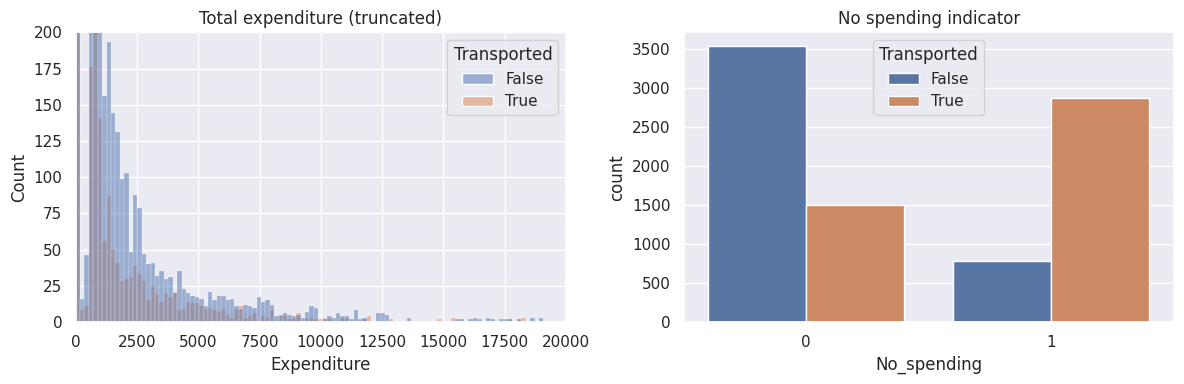

In [ ]:
# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train, x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()


"Transported"에 대한 소비 사용 패턴을 보았을 때, 소비하지 않는 인원이 "Transported" 할 경우가 높다.

따라서 "Transported"할 경우를 줄이기 위해서는 소비 사용을 권장해야 하며, "Transported"하는 인원들의 소비 금액은 대부분 대략 500~2500사이로 추정된다.

In [ ]:
# New feature - Group
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# New feature - Group size
train['Group_size']=train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['Group_size']=test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

In [ ]:
# New feature
train['Solo']=(train['Group_size']==1).astype(int)
test['Solo']=(test['Group_size']==1).astype(int)

(0.0, 3000.0)

Creating legend with loc="best" can be slow with large amounts of data.
Creating legend with loc="best" can be slow with large amounts of data.


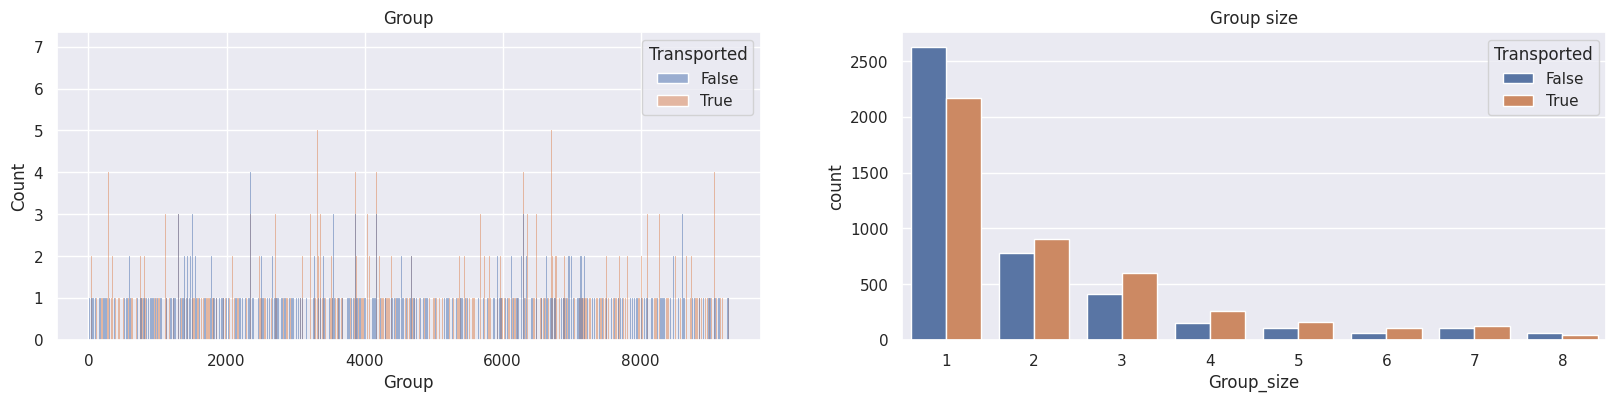

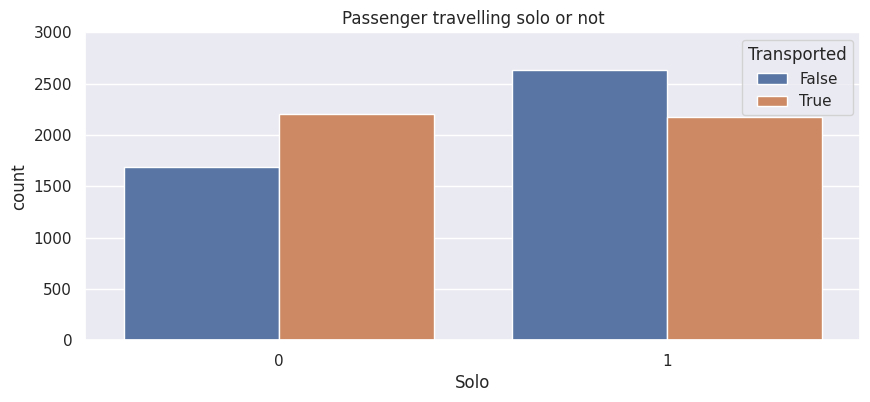

In [ ]:
# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0,3000])

Group size 작을수록 인원이 많이 분포하며, "Transported"의 경우에는 Group size가 클 수록 Transported 비율이 높아짐을 알 수 있다.

Group size를 통해 추출된 "Solo"라는 새로운 컬럼에서 우주선 탑승 시에 동승의 여부에 따른 Transported 비율을 알 수 있다.

In [ ]:
# Replace NaN's with outliers for now (so we can split feature)
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

# New features - training set
train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

# New features - test set
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

# Put Nan's back in (we will fill these later)
train.loc[train['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
train.loc[train['Cabin_number']==9999, 'Cabin_number']=np.nan
train.loc[train['Cabin_side']=='Z', 'Cabin_side']=np.nan
test.loc[test['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
test.loc[test['Cabin_number']==9999, 'Cabin_number']=np.nan
test.loc[test['Cabin_side']=='Z', 'Cabin_side']=np.nan

# Drop Cabin (we don't need it anymore)
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

In [ ]:
# New features - training set
train['Cabin_region1']=(train['Cabin_number']<300).astype(int)   # one-hot encoding
train['Cabin_region2']=((train['Cabin_number']>=300) & (train['Cabin_number']<600)).astype(int)
train['Cabin_region3']=((train['Cabin_number']>=600) & (train['Cabin_number']<900)).astype(int)
train['Cabin_region4']=((train['Cabin_number']>=900) & (train['Cabin_number']<1200)).astype(int)
train['Cabin_region5']=((train['Cabin_number']>=1200) & (train['Cabin_number']<1500)).astype(int)
train['Cabin_region6']=((train['Cabin_number']>=1500) & (train['Cabin_number']<1800)).astype(int)
train['Cabin_region7']=(train['Cabin_number']>=1800).astype(int)

# New features - test set
test['Cabin_region1']=(test['Cabin_number']<300).astype(int)   # one-hot encoding
test['Cabin_region2']=((test['Cabin_number']>=300) & (test['Cabin_number']<600)).astype(int)
test['Cabin_region3']=((test['Cabin_number']>=600) & (test['Cabin_number']<900)).astype(int)
test['Cabin_region4']=((test['Cabin_number']>=900) & (test['Cabin_number']<1200)).astype(int)
test['Cabin_region5']=((test['Cabin_number']>=1200) & (test['Cabin_number']<1500)).astype(int)
test['Cabin_region6']=((test['Cabin_number']>=1500) & (test['Cabin_number']<1800)).astype(int)
test['Cabin_region7']=(test['Cabin_number']>=1800).astype(int)

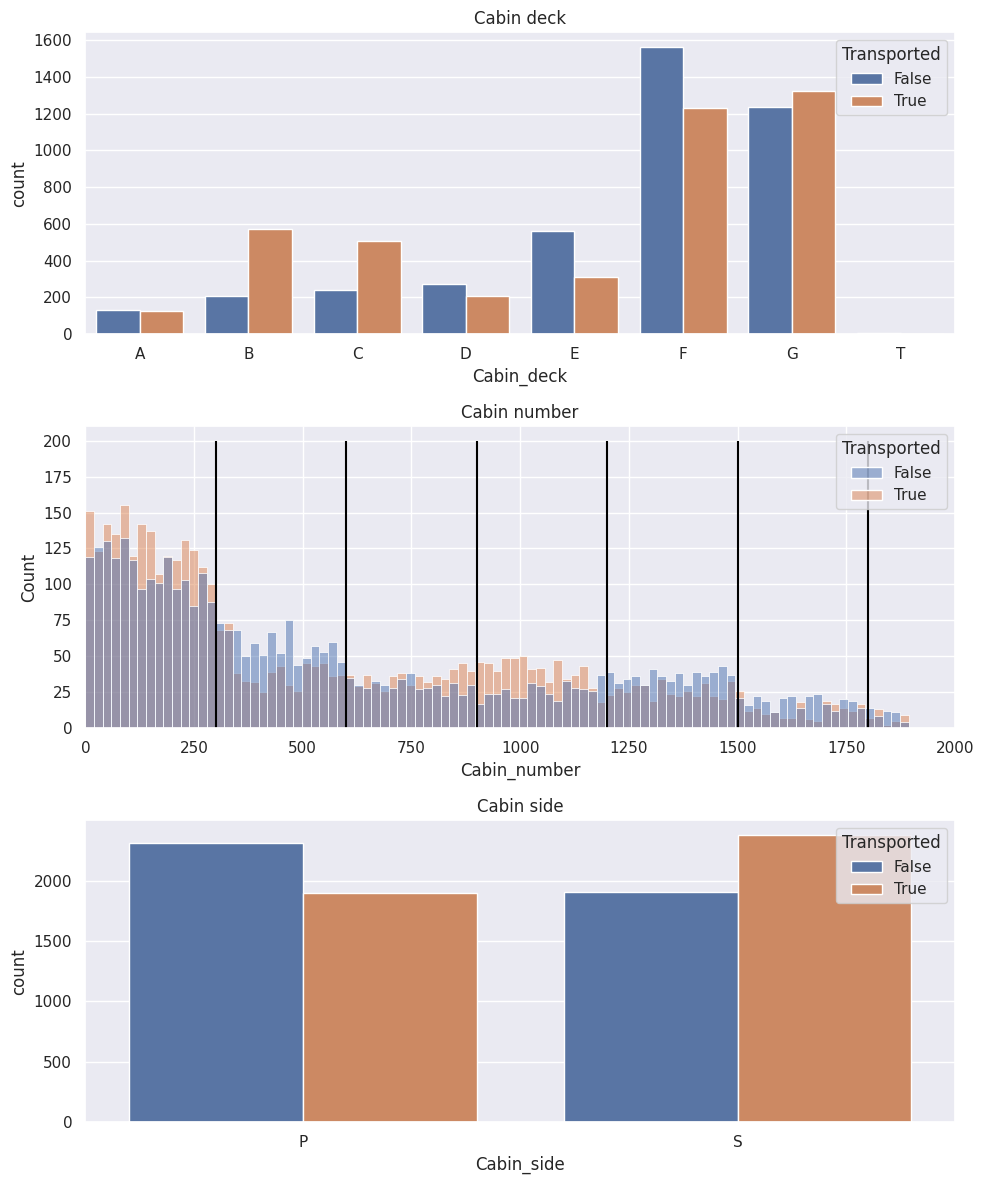

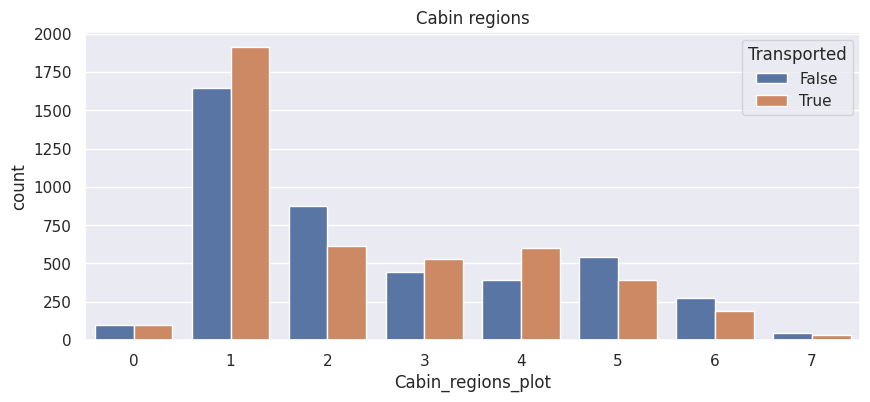

In [ ]:
# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train, x='Cabin_number', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

# Plot distribution of new features
plt.figure(figsize=(10,4))
train['Cabin_regions_plot']=(train['Cabin_region1']+2*train['Cabin_region2']+3*train['Cabin_region3']+4*train['Cabin_region4']+5*train['Cabin_region5']+6*train['Cabin_region6']+7*train['Cabin_region7']).astype(int)
sns.countplot(data=train, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')
train.drop('Cabin_regions_plot', axis=1, inplace=True)

Cabin이라는 승객이 머무르는 객실의 컬럼과 Transported 관계
- Cabin_num "300"기준으로 그룹화
- "F" & "G"에 가장 많은 승객이 있으며, 그 중에서는 Cabin_regions '1'에 많은 인원이 있다.
- "Transported" 관점으로 보았을 때 "G" 객실에서 Cabin_regions '1', 좌현에 머무르는 객실의 승객일 경우 높은 확률로 "Transported"할 것이라 추측된다.
- "Transported"를 줄이기 위해 위에 말한 조건들을 피한다면 줄일 수 있지 않을까?

In [ ]:
# Replace NaN's with outliers for now (so we can split feature)
train['Name'].fillna('Unknown Unknown', inplace=True)
test['Name'].fillna('Unknown Unknown', inplace=True)

# New feature - Surname
train['Surname']=train['Name'].str.split().str[-1]
test['Surname']=test['Name'].str.split().str[-1]

# New feature - Family size
train['Family_size']=train['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])
test['Family_size']=test['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])

# Put Nan's back in (we will fill these later)
train.loc[train['Surname']=='Unknown','Surname']=np.nan
train.loc[train['Family_size']>100,'Family_size']=np.nan
test.loc[test['Surname']=='Unknown','Surname']=np.nan
test.loc[test['Family_size']>100,'Family_size']=np.nan

# Drop name (we don't need it anymore)
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

Text(0.5, 1.0, 'Family size')

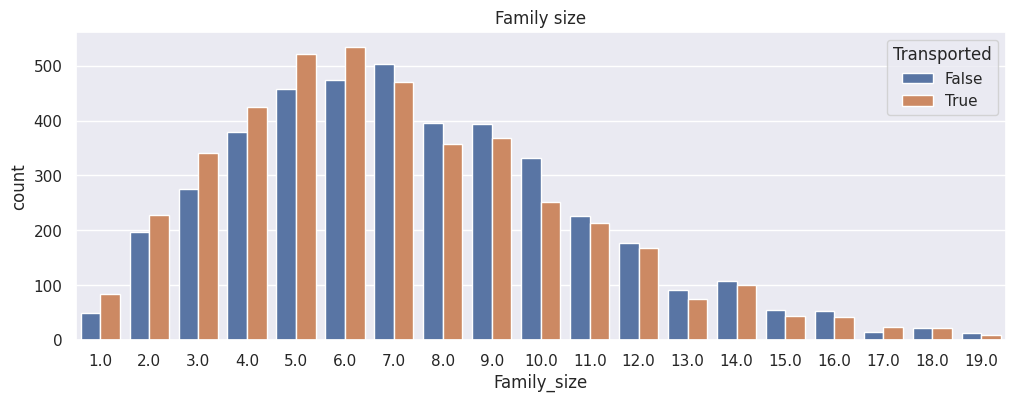

In [ ]:
# New feature distribution
plt.figure(figsize=(12,4))
sns.countplot(data=train, x='Family_size', hue='Transported')
plt.title('Family size')

"Name" 컬럼에서 가족일 경우 성이 동일할 거라 생각하여 "Family"라는 새로운 컬럼을 생성

이를 통한 승객의 가족 단위를 파악, 5~6인 단체 승객인원일 경우에 "Transported"할 경우가 높다는 것을 알 수 있다.

In [ ]:
# Labels and features
y=train['Transported'].copy().astype(int)
X=train.drop('Transported', axis=1).copy()

# Concatenate dataframes
data=pd.concat([X, test], axis=0).reset_index(drop=True)

In [ ]:
# Columns with missing values
na_cols=data.columns[data.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(data),2)
mv

,Number_missing,Percentage_missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


In [ ]:
# Joint distribution of Group and HomePlanet
GHP_gb=data.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


In [ ]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a group with known HomePlanet
GHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

# Fill corresponding missing values
data.loc[GHP_index,'HomePlanet']=data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 288
#HomePlanet missing values after: 157


In [ ]:
# Joint distribution of CabinDeck and HomePlanet
CDHP_gb=data.groupby(['Cabin_deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

In [ ]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Decks A, B, C or T came from Europa
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

# Deck G came from Earth
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='G'), 'HomePlanet']='Earth'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 157
#HomePlanet missing values after: 94


In [ ]:
# Joint distribution of Surname and HomePlanet
SHP_gb=data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

In [ ]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a family with known HomePlanet
SHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

# Fill corresponding missing values
data.loc[SHP_index,'HomePlanet']=data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 94
#HomePlanet missing values after: 10


In [ ]:
# Only 10 HomePlanet missing values left - let's look at them
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]

,PassengerId,HomePlanet,Destination
2274,2443_01,NaN,TRAPPIST-1e
2631,2817_01,NaN,TRAPPIST-1e
3091,3331_01,NaN,TRAPPIST-1e
4548,4840_01,NaN,TRAPPIST-1e
5762,6108_01,NaN,TRAPPIST-1e
8969,0616_01,NaN,TRAPPIST-1e
10583,4052_01,NaN,TRAPPIST-1e
11913,7065_01,NaN,TRAPPIST-1e
12551,8435_01,NaN,TRAPPIST-1e
12725,8775_01,NaN,TRAPPIST-1e


In [ ]:
# Joint distribution of HomePlanet and Destination
HPD_gb=data.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

In [ ]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
data.loc[(data['HomePlanet'].isna()) & ~(data['Cabin_deck']=='D'), 'HomePlanet']='Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='D'), 'HomePlanet']='Mars'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 10
#HomePlanet missing values after: 0


In [ ]:
# Missing values before
D_bef=data['Destination'].isna().sum()

# Fill missing Destination values with mode
data.loc[(data['Destination'].isna()), 'Destination']='TRAPPIST-1e'

# Print number of missing values left
print('#Destination missing values before:',D_bef)
print('#Destination missing values after:',data['Destination'].isna().sum())

#Destination missing values before: 274
#Destination missing values after: 0


In [ ]:
# Joint distribution of Group and Surname
GSN_gb=data[data['Group_size']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)

In [ ]:
# Missing values before
SN_bef=data['Surname'].isna().sum()

# Passengers with missing Surname and in a group with known majority Surname
GSN_index=data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

# Fill corresponding missing values
data.loc[GSN_index,'Surname']=data.iloc[GSN_index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Surname missing values before:',SN_bef)
print('#Surname missing values after:',data['Surname'].isna().sum())

#Surname missing values before: 294
#Surname missing values after: 155


In [ ]:
# Replace NaN's with outliers (so we can use map)
data['Surname'].fillna('Unknown', inplace=True)

# Update family size feature
data['Family_size']=data['Surname'].map(lambda x: data['Surname'].value_counts()[x])

# Put NaN's back in place of outliers
data.loc[data['Surname']=='Unknown','Surname']=np.nan

# Say unknown surname means no family
data.loc[data['Family_size']>100,'Family_size']=0

In [ ]:
# Joint distribution of Group and Cabin features
GCD_gb=data[data['Group_size']>1].groupby(['Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
GCN_gb=data[data['Group_size']>1].groupby(['Group','Cabin_number'])['Cabin_number'].size().unstack().fillna(0)
GCS_gb=data[data['Group_size']>1].groupby(['Group','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

In [ ]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Passengers with missing Cabin side and in a group with known Cabin side
GCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Group']).isin(GCS_gb.index)].index

# Fill corresponding missing values
data.loc[GCS_index,'Cabin_side']=data.iloc[GCS_index,:]['Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 299
#Cabin_side missing values after: 162


In [ ]:
# Joint distribution of Surname and Cabin side
SCS_gb=data[data['Group_size']>1].groupby(['Surname','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

# Ratio of sides
SCS_gb['Ratio']=SCS_gb['P']/(SCS_gb['P']+SCS_gb['S'])

In [ ]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Drop ratio column
SCS_gb.drop('Ratio', axis=1, inplace=True)

# Passengers with missing Cabin side and in a family with known Cabin side
SCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Surname']).isin(SCS_gb.index)].index

# Fill corresponding missing values
data.loc[SCS_index,'Cabin_side']=data.iloc[SCS_index,:]['Surname'].map(lambda x: SCS_gb.idxmax(axis=1)[x])

# Drop surname (we don't need it anymore)
data.drop('Surname', axis=1, inplace=True)

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 162
#Cabin_side missing values after: 66


In [ ]:
# Value counts
data['Cabin_side'].value_counts()

S    6504
P    6400
Name: Cabin_side, dtype: int64

In [ ]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Fill remaining missing values with outlier
data.loc[data['Cabin_side'].isna(),'Cabin_side']='Z'

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 66
#Cabin_side missing values after: 0


In [ ]:
# Missing values before
CD_bef=data['Cabin_deck'].isna().sum()

# Passengers with missing Cabin deck and in a group with known majority Cabin deck
GCD_index=data[data['Cabin_deck'].isna()][(data[data['Cabin_deck'].isna()]['Group']).isin(GCD_gb.index)].index

# Fill corresponding missing values
data.loc[GCD_index,'Cabin_deck']=data.iloc[GCD_index,:]['Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Cabin_deck missing values before:',CD_bef)
print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 299
#Cabin_deck missing values after: 162


In [ ]:
# Joint distribution
data.groupby(['HomePlanet','Destination','Solo','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)

Cabin_deck                         A      B      C      D      E       F  \
HomePlanet Destination   Solo                                              
Earth      55 Cancri e   0       0.0    0.0    0.0    0.0   20.0    90.0   
                         1       0.0    0.0    0.0    0.0   47.0   289.0   
           PSO J318.5-22 0       0.0    0.0    0.0    0.0   18.0    67.0   
                         1       0.0    0.0    0.0    0.0   25.0   262.0   
           TRAPPIST-1e   0       0.0    0.0    0.0    0.0  133.0   438.0   
                         1       0.0    0.0    0.0    0.0  358.0  1350.0   
Europa     55 Cancri e   0      96.0  377.0  313.0   59.0   35.0     0.0   
                         1      67.0  141.0  159.0   46.0   34.0     0.0   
           PSO J318.5-22 0       2.0    5.0   11.0    0.0    0.0     0.0   
                         1       0.0    0.0   10.0    0.0    0.0     0.0   
           TRAPPIST-1e   0     152.0  459.0  428.0  120.0   53.0     0.0   
                         1      44.0  179.0  201.0   84.0   82.0     0.0   
Mars       55 Cancri e   0       0.0    0.0    0.0   32.0   15.0   104.0   
                         1       0.0    0.0    0.0   40.0   16.0    92.0   
           PSO J318.5-22 0       0.0    0.0    0.0    8.0    9.0    14.0   
                         1       0.0    0.0    0.0    9.0    7.0    21.0   
           TRAPPIST-1e   0       0.0    0.0    0.0  168.0  219.0   798.0   
                         1       0.0    0.0    0.0  164.0  263.0   743.0   

Cabin_deck                          G    T  
HomePlanet Destination   Solo               
Earth      55 Cancri e   0      272.0  0.0  
                         1      269.0  0.0  
           PSO J318.5-22 0      230.0  0.0  
                         1      466.0  0.0  
           TRAPPIST-1e   0     1075.0  0.0  
                         1     1509.0  0.0  
Europa     55 Cancri e   0        0.0  2.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  1.0  
                         1        0.0  8.0  
Mars       55 Cancri e   0        0.0  0.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  0.0  
                         1        0.0  0.0

In [ ]:
# Missing values before
CD_bef=data['Cabin_deck'].isna().sum()

# Fill missing values using the mode
na_rows_CD=data.loc[data['Cabin_deck'].isna(),'Cabin_deck'].index
data.loc[data['Cabin_deck'].isna(),'Cabin_deck']=data.groupby(['HomePlanet','Destination','Solo'])['Cabin_deck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CD]

# Print number of missing values left
print('#Cabin_deck missing values before:',CD_bef)
print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 162
#Cabin_deck missing values after: 0


In [ ]:
# Missing values before
CN_bef=data['Cabin_number'].isna().sum()

# Extrapolate linear relationship on a deck by deck basis
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    # Features and labels
    X_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']
    y_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']
    X_test_CN=data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']

    # Linear regression
    model_CN=LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
    preds_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))

    # Fill missing values with predictions
    data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']=preds_CN.astype(int)

# Print number of missing values left
print('#Cabin_number missing values before:',CN_bef)
print('#Cabin_number missing values after:',data['Cabin_number'].isna().sum())

#Cabin_number missing values before: 299
#Cabin_number missing values after: 0


In [ ]:
# One-hot encode cabin regions
data['Cabin_region1']=(data['Cabin_number']<300).astype(int)
data['Cabin_region2']=((data['Cabin_number']>=300) & (data['Cabin_number']<600)).astype(int)
data['Cabin_region3']=((data['Cabin_number']>=600) & (data['Cabin_number']<900)).astype(int)
data['Cabin_region4']=((data['Cabin_number']>=900) & (data['Cabin_number']<1200)).astype(int)
data['Cabin_region5']=((data['Cabin_number']>=1200) & (data['Cabin_number']<1500)).astype(int)
data['Cabin_region6']=((data['Cabin_number']>=1500) & (data['Cabin_number']<1800)).astype(int)
data['Cabin_region7']=(data['Cabin_number']>=1800).astype(int)

In [ ]:
data['VIP'].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

In [ ]:
# Missing values before
V_bef=data['VIP'].isna().sum()

# Fill missing values with mode
data.loc[data['VIP'].isna(),'VIP']=False

# Print number of missing values left
print('#VIP missing values before:',V_bef)
print('#VIP missing values after:',data['VIP'].isna().sum())

#VIP missing values before: 296
#VIP missing values after: 0


In [ ]:
# Joint distribution
data.groupby(['HomePlanet','No_spending','Solo','Cabin_deck'])['Age'].median().unstack().fillna(0)

Cabin_deck                      A     B     C     D     E     F     G     T
HomePlanet No_spending Solo                                                
Earth      0           0      0.0   0.0   0.0   0.0  24.0  25.0  28.0   0.0
                       1      0.0   0.0   0.0   0.0  25.0  24.0  26.0   0.0
           1           0      0.0   0.0   0.0   0.0   7.0  16.0   8.0   0.0
                       1      0.0   0.0   0.0   0.0  21.0  21.5  23.0   0.0
Europa     0           0     35.0  34.0  33.0  33.0  34.0   0.0   0.0  44.0
                       1     35.0  36.0  35.5  34.0  35.0   0.0   0.0  35.0
           1           0     30.0  27.0  28.5  27.0  28.0   0.0   0.0   0.0
                       1     37.5  34.0  35.0  31.0  33.0   0.0   0.0   0.0
Mars       0           0      0.0   0.0   0.0  30.0  29.0  29.0   0.0   0.0
                       1      0.0   0.0   0.0  31.0  28.5  30.0   0.0   0.0
           1           0      0.0   0.0   0.0  29.5  26.0  18.0   0.0   0.0
                       1      0.0   0.0   0.0  33.0  30.0  29.5   0.0   0.0

In [ ]:
# Missing values before
A_bef=data[exp_feats].isna().sum().sum()

# Fill missing values using the median
na_rows_A=data.loc[data['Age'].isna(),'Age'].index
data.loc[data['Age'].isna(),'Age']=data.groupby(['HomePlanet','No_spending','Solo','Cabin_deck'])['Age'].transform(lambda x: x.fillna(x.median()))[na_rows_A]

# Print number of missing values left
print('#Age missing values before:',A_bef)
print('#Age missing values after:',data['Age'].isna().sum())

#Age missing values before: 1410
#Age missing values after: 0


In [ ]:
# Update age group feature
data.loc[data['Age']<=12,'Age_group']='Age_0-12'
data.loc[(data['Age']>12) & (data['Age']<18),'Age_group']='Age_13-17'
data.loc[(data['Age']>=18) & (data['Age']<=25),'Age_group']='Age_18-25'
data.loc[(data['Age']>25) & (data['Age']<=30),'Age_group']='Age_26-30'
data.loc[(data['Age']>30) & (data['Age']<=50),'Age_group']='Age_31-50'
data.loc[data['Age']>50,'Age_group']='Age_51+'

In [ ]:
# Joint distribution
data.groupby(['No_spending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
No_spending,,
0,7339.0,0.0
1,740.0,4581.0


In [ ]:
# Missing values before
CSL_bef=data['CryoSleep'].isna().sum()

# Fill missing values using the mode
na_rows_CSL=data.loc[data['CryoSleep'].isna(),'CryoSleep'].index
data.loc[data['CryoSleep'].isna(),'CryoSleep']=data.groupby(['No_spending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CSL]

# Print number of missing values left
print('#CryoSleep missing values before:',CSL_bef)
print('#CryoSleep missing values after:',data['CryoSleep'].isna().sum())

#CryoSleep missing values before: 310
#CryoSleep missing values after: 0


In [ ]:
print('Maximum expenditure of passengers in CryoSleep:',data.loc[data['CryoSleep']==True,exp_feats].sum(axis=1).max())

Maximum expenditure of passengers in CryoSleep: 0.0


In [ ]:
# Missing values before
E_bef=data[exp_feats].isna().sum().sum()

# CryoSleep has no expenditure
for col in exp_feats:
    data.loc[(data[col].isna()) & (data['CryoSleep']==True), col]=0

# Print number of missing values left
print('#Expenditure missing values before:',E_bef)
print('#Expenditure missing values after:',data[exp_feats].isna().sum().sum())

#Expenditure missing values before: 1410
#Expenditure missing values after: 866


In [ ]:
# Joint distribution
data.groupby(['HomePlanet','Solo','Age_group'])['Expenditure'].mean().unstack().fillna(0)

Age_group        Age_0-12    Age_13-17    Age_18-25    Age_26-30    Age_31-50  \
HomePlanet Solo                                                                 
Earth      0          0.0   724.902222   789.700555   841.093596   736.655773   
           1          0.0   693.014898   779.395942   795.420690   794.818627   
Europa     0          0.0  1153.160256  2652.013298  3534.668246  3975.774005   
           1          0.0     0.000000  2489.888889  3806.000000  3949.939929   
Mars       0          0.0  1176.839286  1161.808333  1247.098361  1143.671916   
           1          0.0  1687.261538  1075.341146  1107.122677  1110.392045   

Age_group            Age_51+  
HomePlanet Solo               
Earth      0      733.649573  
           1      826.366972  
Europa     0     3483.639004  
           1     3952.085526  
Mars       0     1345.419643  
           1     1100.298387

In [ ]:
# Missing values before
E_bef=data[exp_feats].isna().sum().sum()

# Fill remaining missing values using the median
for col in exp_feats:
    na_rows=data.loc[data[col].isna(),col].index
    data.loc[data[col].isna(),col]=data.groupby(['HomePlanet','Solo','Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]

# Print number of missing values left
print('#Expenditure missing values before:',E_bef)
print('#Expenditure missing values after:',data[exp_feats].isna().sum().sum())

#Expenditure missing values before: 866
#Expenditure missing values after: 0


In [ ]:
# Update expenditure and no_spending
data['Expenditure']=data[exp_feats].sum(axis=1)
data['No_spending']=(data['Expenditure']==0).astype(int)

In [ ]:
data.isna().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Age_group        0
Expenditure      0
No_spending      0
Group            0
Group_size       0
Solo             0
Cabin_deck       0
Cabin_number     0
Cabin_side       0
Cabin_region1    0
Cabin_region2    0
Cabin_region3    0
Cabin_region4    0
Cabin_region5    0
Cabin_region6    0
Cabin_region7    0
Family_size      0
dtype: int64

# 데이터 전처리

##  **1. 학습 / 훈련 데이터 세팅**

In [ ]:
# 특성 엔지니어링을 위해 합쳤던 학습 데이터와 훈련 데이터를 분리
# train과 test의 각 PassnegerId를 기준으로 각각 X와 X_test에 데이터를 할당
X=data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
X_test=data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

In [ ]:
# 모델 학습에 불 필요한 컬럼을 제거
X.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)

## **2. 데이터 스케일링**

주어진 열(컬럼) 목록에 대해 로그 변환을 통해 데이터의 분포를 조정하여 모델 학습에 도움이 되도록 조정

숫자형 데이터에 대해 평균이 0이고 분산이 1인 표준 스케일링을 수행
숫자 데이터를 조정하여 학습 알고리즘이 더 잘 작동하도록 함

범주형 데이터에 대해 OneHotEncoder를 통한 인코딩을 수행
범주형 변수를 수치형으로 변환하여 모델 학습에 사용할 수 있도록 함


In [ ]:
# 로그 변환 적용
for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure']:
    X[col] = np.log(1 + X[col])
    X_test[col] = np.log(1 + X_test[col])

# 숫자 및 범주형 열 식별
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# 숫자 데이터를 평균 = 0 및 분산 = 1 로 스케일 조정
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# 범주형 데이터를 OneHotEncoder를 사용한 인코딩
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False))])

# 전처리 결합
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
    remainder='passthrough')

# 전처리 적용
X = ct.fit_transform(X)
X_test = ct.transform(X_test)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [ ]:
# 데이터를 훈련 세트와 검증 세트로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

# 모델 학습
1. RandomForest, LogisticRegression 두 모델을 기본으로 사용
2. GridSearch 또는 RandomSearch를 통해 최적 파라미터를 탐색
3. 최적 파라미터를 튜닝해 데이터 학습 후 정확도 점수 확인
4. 정확도 점수가 높게 나온 모델을 통해 최적 파라미터 탐색 반복

추가로 Kaggle에서 공개된 Code를 참고해 성능이 가장 좋게 나타났던 CatBoostClassifier 모델 또한 사용 후 결과 확인

## **1. RandomForest**

In [ ]:
# RandomForest의 파라미터 정의
rf_param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', 'log2', 0.5, None]
}

In [ ]:
# Grid Search 객체 생성
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=0), param_grid=rf_param_grid, cv=5)

In [ ]:
# 최적 모델 탐색을 위한 GridSearch 진행
rf_grid_search.fit(X_train, y_train)

In [ ]:
# 최적 파라미터와 해당 파라미터의 점수 출력
rf_best_params = rf_grid_search.best_params_
rf_best_score = rf_grid_search.best_score_
print("Best parameters:", rf_best_params)
print("Best score:", rf_best_score)

Best parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best score: 0.8129130225654129


In [ ]:
# 최적의 하이퍼파라미터로 랜덤 포레스트 모델 초기화
rf_best_params = rf_grid_search.best_params_
rf_best_model = RandomForestClassifier(**rf_best_params)

# 전체 훈련 데이터에 대해 모델 학습
rf_best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=300)

In [ ]:
# rf_best_result에 예측 결과 초기화
rf_best_result = rf_best_model.predict(X_test)

In [ ]:
# 예측 결과를 Kaggle 제출 양식에 맞게 변환
rf_submission = pd.DataFrame({'PassengerId': test['PassengerId']})
rf_bs_bool = rf_best_result.astype(bool)
rf_submission['Transported'] = rf_bs_bool

# 제출 양식에 맞춘 데이터를 csv 파일로 Export
rf_submission.to_csv('RandomForest_result.csv', index=False)

## **2. LogisticRegression**

In [ ]:
# LogisticRegression의 파라미터 정의
lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced'],
    'multi_class': ['ovr', 'multinomial']
}

In [ ]:
# Grid Search 객체 생성
lr_grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=lr_param_grid, cv=5)

In [ ]:
# 최적 모델 탐색을 위한 GridSearch 진행
lr_grid_search.fit(X_train, y_train)

In [ ]:
# 최적 파라미터와 해당 파라미터의 점수 출력
lr_best_params = lr_grid_search.best_params_
lr_best_score = lr_grid_search.best_score_
print("Best parameters:", lr_best_params)
print("Best score:", lr_best_score)

Best parameters: {'C': 0.01, 'class_weight': None, 'max_iter': 100, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.7832915608562754


In [ ]:
# 최적의 하이퍼파라미터로 랜덤 포레스트 모델 초기화
lr_best_params = lr_grid_search.best_params_
lr_best_model = LogisticRegression(**lr_best_params)

# 전체 훈련 데이터에 대해 모델 학습
lr_best_model.fit(X_train, y_train)

LogisticRegression(C=0.01, multi_class='ovr', solver='liblinear')

In [ ]:
# lr_best_result에 예측 결과 초기화
lr_best_result = lr_best_model.predict(X_test)

In [ ]:
# 예측 결과를 Kaggle 제출 양식에 맞게 변환
lr_submission = pd.DataFrame({'PassengerId': test['PassengerId']})
lr_bs_bool = lr_best_result.astype(bool)
lr_submission['Transported'] = lr_bs_bool

# 제출 양식에 맞춘 데이터를 csv 파일로 Export
lr_submission.to_csv('LogisticRegression_result.csv', index=False)

## **3. CatBoostClassifier**

In [ ]:
# CatBoostClassifier의 파라미터 정의
cb_param_dist = {
    'depth': [4, 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

In [ ]:
# Random Search 객체 생성
cb_random_search = RandomizedSearchCV(CatBoostClassifier(), param_distributions=cb_param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)

In [ ]:
# 최적 모델 탐색을 위한 Random Search 진행
cb_random_search.fit(X_train, y_train)

In [ ]:
# 최적 파라미터와 해당 파라미터의 점수 출력
cb_best_params = cb_random_search.best_params_
cb_best_score = cb_random_search.best_score_
print("Best parameters:", cb_best_params)
print("Best score:", cb_best_score)

Best parameters: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'depth': 5}
Best score: 0.8129139535244558


In [ ]:
# 최적의 하이퍼파라미터로  CatBoostClassifier 모델 초기화
cb_best_params = cb_random_search.best_params_
cb_best_model = CatBoostClassifier(**cb_best_params)

# 전체 훈련 데이터에 대해 모델 학습
cb_best_model.fit(X_train, y_train)

In [ ]:
# cb_best_result에 예측 결과 초기화
cb_best_result = cb_best_model.predict(X_test)

In [ ]:
# 예측 결과를 Kaggle 제출 양식에 맞게 변환
cb_submission = pd.DataFrame({'PassengerId': test['PassengerId']})
cb_bs_bool = cb_best_result.astype(bool)
cb_submission['Transported'] = cb_bs_bool

# 제출 양식에 맞춘 데이터를 csv 파일로 Export
cb_submission.to_csv('CatBoostClassifier_result.csv', index=False)

# 모델 검증
- ROC Curve와 AUC를 계산 후 시각화

In [ ]:
# 모델 리스트 정의
models = [rf_best_model, lr_best_model, cb_best_model]

# 모델명 리스트 정의
model_names = ['RandomForest', 'LogisticRegression', 'CatBoost']

# 모델별 결과 변수 리스트 정의
results = [rf_best_result, lr_best_result, cb_best_result]

In [ ]:
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_valid)[:, 1]
    fpr, tpr, _ = roc_curve(y_valid, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.legend(loc="lower right", fontsize='large', title='Model')
plt.show()

# 결과

## **1. ROC Curve롤 통한 검증 결과**

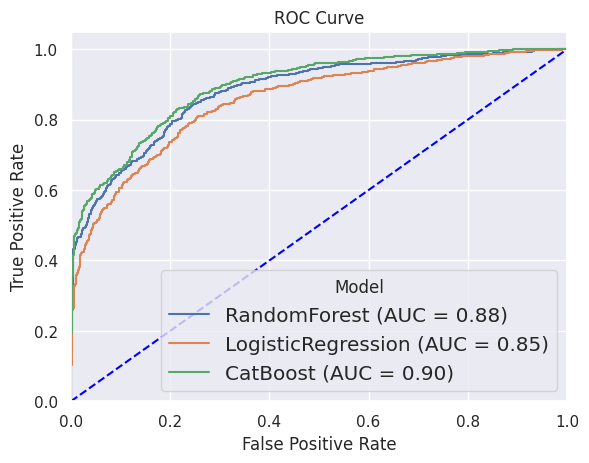

ROC Curve는 왼쪽 위에 가까울수록 우수한 성능을 가진다고 할 수 있음

CatBoost, RandomForest, LogisticRegression 순서로 성능이 좋게 나타남

따라서 CatBoost가 해당 데이터에 대해 가장 우수한 성능을 보이는 모델이라고 할 수 있음

## **2. 각 모델의 최적 모델의 성능 평가 점수**

#### RandomForest의 결과물
```
Best parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best score: 0.8129130225654129
```

#### LogisticRegression의 결과물
```
Best parameters: {'C': 0.01, 'class_weight': None, 'max_iter': 100, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.7832915608562754
```

#### CatBoost의 결과물
```
Best parameters: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'depth': 5}
Best score: 0.8129139535244558
```

## **2. Kaggle 제출을 통한 검증 결과**

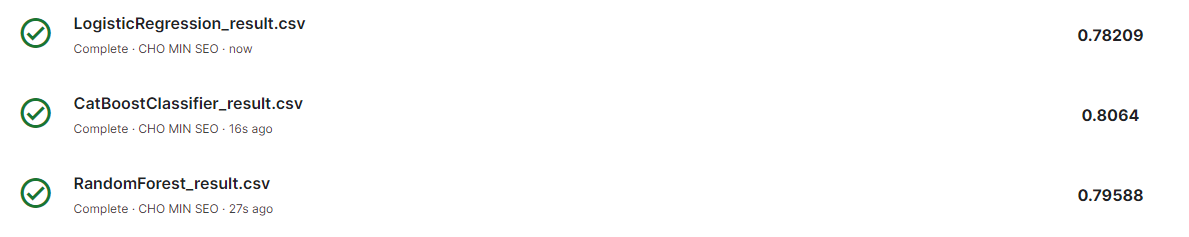

ROC Curve에서 본 결과와 같이 CatBoost 모델이 가장 우수한 결과를 보임\
그 뒤로 RandomForest, LogisticRegression의 순서로 성능이 좋았음

## **3. 최적 모델을 통한 데이터 해석**
SHAP(SHapley Additive exPlanations)를 통해 최적 모델의 예측을 해석
- 각 feature가 얼마나 영향을 주는지 확인

In [ ]:
# SHAP 값을 계산
explainer = shap.Explainer(cb_best_model)
shap_values = explainer.shap_values(X_train)

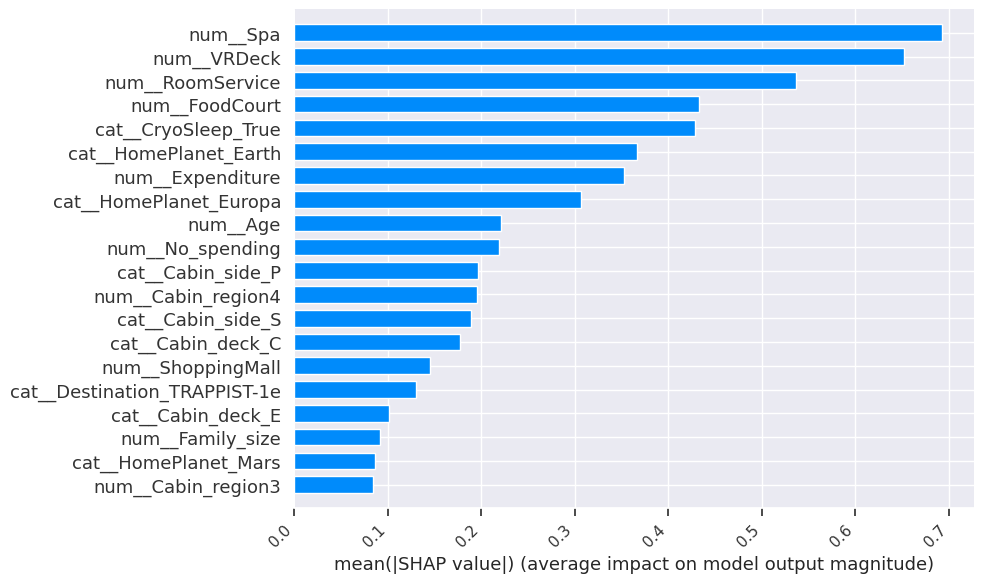

In [ ]:
# SHAP 요약 플롯 생성
shap.summary_plot(shap_values, X_train, plot_type="bar", class_names=cb_best_model.classes_, feature_names=ct.get_feature_names_out(), plot_size=(10, 6), show=False)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Spa, VR_Deck, RoomService, FoodCourt 와 같이 금액을 지불하는 서비스를 사용했는지의 여부가 생존에 있어 가장 중요한 feature로 나타남

Cryo Sleep의 경우 값이 True인 경우 위 4개의 데이터에 대해서 값이 모두 0으로 나타나는 특징이 있기 때문에 그 다음으로 영향이 높게 나타남

결과적으로 돈을 지불하는 유료 서비스의 사용 여부가 Transported의 값을 결정짓는 가장 중요한 요소라고 할 수 있음